In [1]:
import os
import json
import time
import random
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Setting variables

In [2]:
# yelp_path = 'C:/Users/Kamil/Desktop'
yelp_path = '/Users/kamil/Desktop/yelp_dataset'

business_data_limit = None
review_data_limit = 10**7

business_path = os.path.join(yelp_path, 'yelp_academic_dataset_business.json')
review_path = os.path.join(yelp_path, 'yelp_academic_dataset_review.json')

### Load data

The method reads 'business_id' and 'categories' columns from the businesses file

In [3]:
def load_business_data(path, limit=None):
    business_data = {}
    with open(business_path, encoding='utf8') as file:
        for index, line in enumerate(file):
            if limit is not None and index >= limit:
                break

            row = json.loads(line)
            business_data[row['business_id']] = row['categories']
            
    return business_data

The method reads 'business_id' and 'text' columns from the reviews file and merging them with 'categories' column from business file

In [4]:
def load_review_data(path, business_data, limit=review_data_limit):
    data = []
    with open(review_path, encoding='utf8') as file:
        for index, line in enumerate(file):
            if limit is not None and index > limit:
                break

            row = json.loads(line)
            categories = business_data.get(row['business_id'])
            if categories is not None:
                categories = [category for category in categories.replace(' ', '').split(',')]
                data.append([row['text'], categories])      
                
    return data

The method loads data that are of the main_categories

In [5]:
def load_review_dict(path, business_data, main_categories, only_one_category=False, limit=review_data_limit):
    data = {category: [] for category in main_categories}
    
    with open(review_path, encoding='utf8') as file:
        for index, line in enumerate(file):
            if limit is not None and index > limit:
                break

            row = json.loads(line)
            categories = business_data.get(row['business_id'])
            if categories is not None:
                categories = categories.replace(' ', '').split(',')
                categories = [category for category in categories if category in main_categories]
                
                if only_one_category:
                    if len(categories) != 1:
                        continue
                    data[categories[0]].append(row['text'])
                else:
                    for category in categories:
                        data[category].append(row['text'])
                
    return data

In [6]:
business_data = load_business_data(business_path, limit=business_data_limit)
review_data = load_review_data(review_path, business_data, limit=review_data_limit)

### Visualize data

The method take the categories with the most reviews and sorts them

In [26]:
def filter_sort(review_data, only_one_category=False, threshold=1000):
    categories_count = {}
    for data in review_data:
        categories = data[1]
        
        if only_one_category:
            categories = [categories]
            
        for category in categories:
            if category not in categories_count:
                categories_count[category] = 1
            else:
                categories_count[category] += 1
    
    category_count = [(category, count) for category, count in categories_count.items() if count >= threshold]
    category_count.sort(key=lambda x : x[1], reverse=True)
    
    return category_count

The method visualizes filtered data

In [8]:
def visualize_data(filtered, limit=100):
    if len(filtered) > limit:
        filtered = filtered[0:limit]
    else:
        limit = len(filtered)
    
    y, x = zip(*filtered)
    y = [str(y_) for y_ in y]
    plt.figure(figsize=(12, 0.25*len(y)))
    
    plt.plot(x, y, 'r.', label='The amount of reviews (points)')
    plt.plot(x, y, 'b', label='The amount of reviews (line)', linewidth=0.5)
    
    x_max = np.max(x)
    plt.xticks(np.arange(0, x_max, int(x_max/15.0)))
    
    plt.title(f'The plot shows the amount of reviews for {limit} best categories')
    plt.xlabel('Count')
    plt.ylabel('Categories')
    plt.legend()
    
    plt.show()

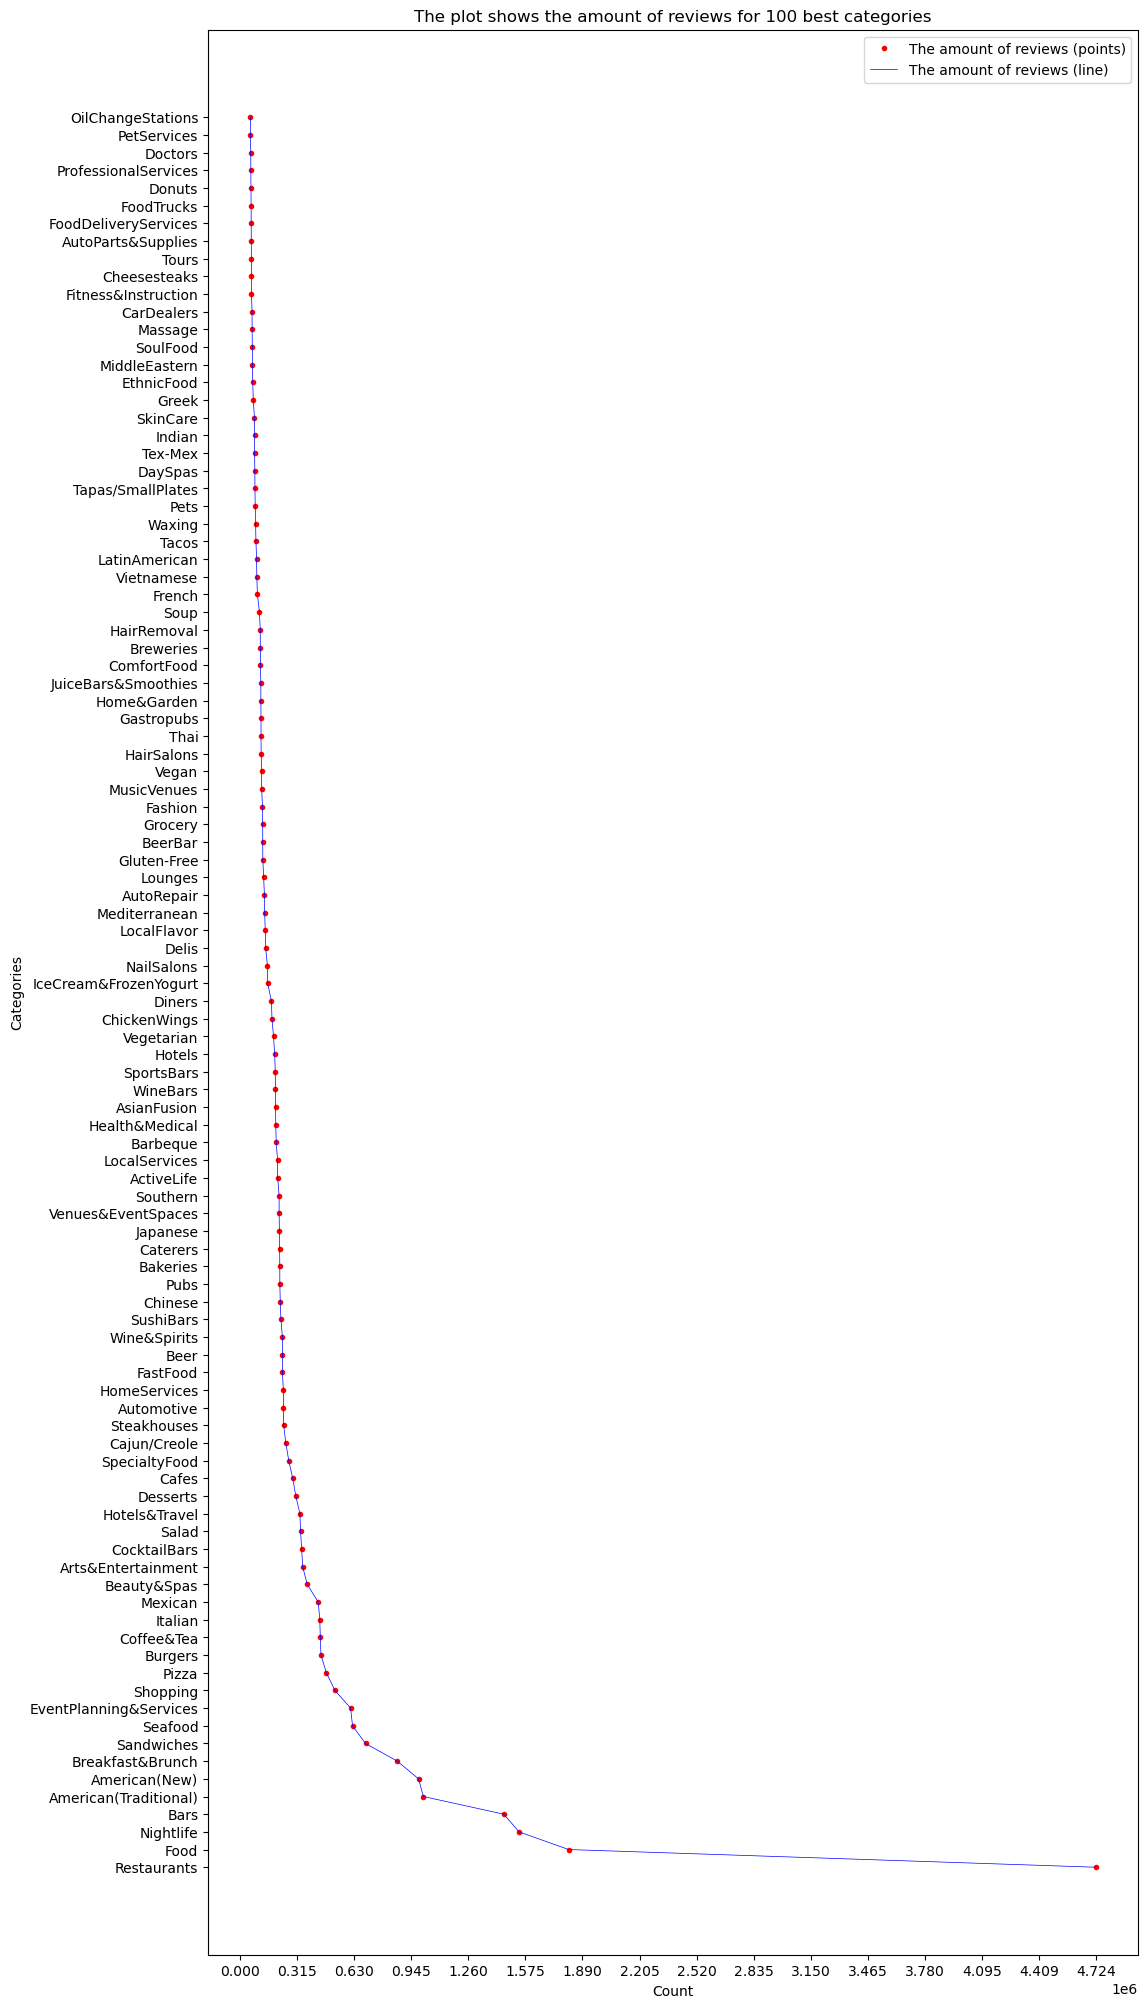

In [9]:
filtered = filter_sort(review_data)
visualize_data(filtered)

### Pick relevant categories with the most reviews

The following set is created by picking the most relevant categories with the most reviews from the above plot

In [10]:
main_categories = set([
    'Restaurants', 'Food', 'Nightlife', 'Bars', 
    'Breakfast&Brunch', 'Sandwiches', 'Seafood', 'EventPlanning&Services', 'Shopping', 'Pizza', 
    'Burgers', 'Coffee&Tea', 'Beauty&Spas', 'Arts&Entertainment', 
    'CocktailBars', 'Salad', 'Hotels&Travel', 'Desserts', 'Cafes', 'Automotive', 
    'HomeServices', 'FastFood', 'Beer', 'Wine&Spirits', 'SushiBars', 'Pubs', 'Bakeries', 'Caterers', 
    'Venues&EventSpaces', 'ActiveLife', 'LocalServices', 'Barbeque', 
    'Health&Medical', 'WineBars', 'SportsBars', 'Hotels', 'Vegetarian', 
    'IceCream&FrozenYogurt', 'NailSalons', 'LocalFlavor', 
    'AutoRepair', 'Lounges', 'Gluten-Free', 'Grocery', 
    'Fashion', 'MusicVenues', 'Vegan', 'HairSalons', 'Karaoke',
    'Home&Garden', 'JuiceBars&Smoothies', 'Pets', 'Massage', 'CarDealers', 'Fitness&Instruction', 
    'Tours', 'AutoParts&Supplies', 'FoodTrucks', 'Dance Clubs',
    'ProfessionalServices', 'Doctors', 'PetServices', 'Education'
])

In [11]:
print(f'Found {len(main_categories)} main categories')

Found 63 main categories


### Create training, validating & testing datasets

The method creates dictionary of 'category_string' -> 'category_integer'

In [9]:
def create_classes_dict(labels):
    result = {}
    for index, label in enumerate(labels):
        result[label] = index
    return result

The method truncates the amount of data

In [10]:
def truncate_review_data(review_data, limit=3000):
    for category, data in review_data.items():
        if len(data) > limit:
            review_data[category] = random.sample(data, k=limit)
            
    return review_data

The method changes data from dict form to list form. Moreover it changes string categories to proper integer values

In [11]:
def dict_to_list_review(review_data, category_dict, only_one_category=False):
    buffer = {}
    for category, texts in review_data.items():
        for text in texts:
            if text not in buffer:
                buffer[text] = [category_dict[category]]
            else:
                buffer[text].append(category_dict[category])
                
    if only_one_category:
        return [[text, categories[0]] for text, categories in buffer.items()]        
    else:
        return [[text, categories] for text, categories in buffer.items()]

Load data with the chosen categories & truncate data. Create dictionary for labels

In [15]:
review_data = load_review_dict(review_path, business_data, main_categories, limit=review_data_limit)
review_data = truncate_review_data(review_data, limit=50000)
label_dict = create_classes_dict(main_categories)

Finally change the dict to list format and apply label dict on the whole dataset

In [16]:
data = dict_to_list_review(review_data, label_dict)

### Visualize final dataset

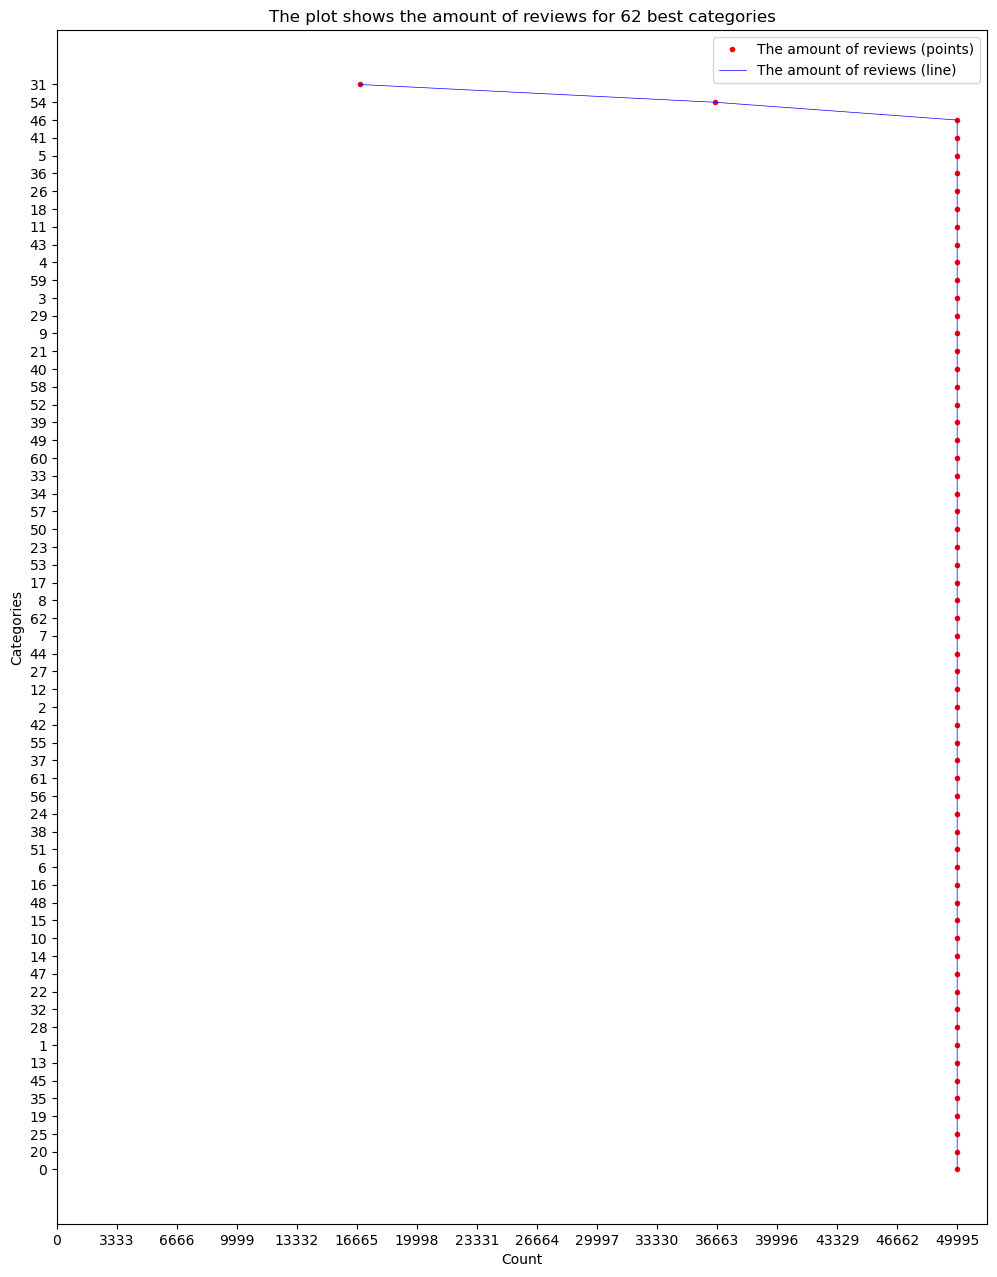

In [17]:
visualize_data(filter_sort(data))

In [18]:
print(f'final_clases ({len(label_dict)}):\n{label_dict}')

final_clases (63):
{'PetServices': 0, 'Hotels': 1, 'LocalFlavor': 2, 'IceCream&FrozenYogurt': 3, 'Sandwiches': 4, 'Vegan': 5, 'HairSalons': 6, 'Venues&EventSpaces': 7, 'Breakfast&Brunch': 8, 'Wine&Spirits': 9, 'Fashion': 10, 'FastFood': 11, 'Beauty&Spas': 12, 'Home&Garden': 13, 'HomeServices': 14, 'Cafes': 15, 'ActiveLife': 16, 'MusicVenues': 17, 'Grocery': 18, 'ProfessionalServices': 19, 'Pets': 20, 'Burgers': 21, 'Massage': 22, 'AutoRepair': 23, 'Automotive': 24, 'LocalServices': 25, 'FoodTrucks': 26, 'Food': 27, 'EventPlanning&Services': 28, 'Seafood': 29, 'Dance Clubs': 30, 'Karaoke': 31, 'Arts&Entertainment': 32, 'Beer': 33, 'Caterers': 34, 'Shopping': 35, 'JuiceBars&Smoothies': 36, 'NailSalons': 37, 'Restaurants': 38, 'CocktailBars': 39, 'Desserts': 40, 'Barbeque': 41, 'Tours': 42, 'Pizza': 43, 'AutoParts&Supplies': 44, 'Health&Medical': 45, 'CarDealers': 46, 'Doctors': 47, 'Hotels&Travel': 48, 'Vegetarian': 49, 'Bars': 50, 'Fitness&Instruction': 51, 'Salad': 52, 'Pubs': 53, 'Edu

In [19]:
with open(f'../data/nn_data_{int(time.time())}.pickle', 'wb') as handle:
    pickle.dump(data, handle)

In [20]:
with open(f'../data/dictionary_{int(time.time())}.pickle', 'wb') as handle:
    pickle.dump(label_dict, handle)

### Create smaller dataset with only one label per sample

In [50]:
main_categories = set([
    # active live
    'Beaches', 'Bowling', 'Climbing', 'Diving', 'Fishing', 'Golf', 'Paintball',
    
    # arts & entertainment
    'Museums', 'Cinema',
    
    # automotive
    'Parking',
    
    # Beauty & Spas
    'Barbers', 'Massage', 'Perfume', 'Tattoo',
    
    # Food
    'Bakeries', 'Grocery',
    
    # Health & Medical
    'Hospitals', 'Pharmacy', 'Saunas',
    
    # Hotels & Travel
    'Airports', 'Hostels', 'Hotels', 'Tours', 'Transportation',
    
    # Nightlife
    'Bars', 'Karaoke',
    
    # Public Services & Government
    'Embassy', 'Libraries',

    # Restaurants
    'Cafes', 'Diners', 'Kebab', 'Pizza', 'Noodles', 'Sandwiches', 'Seafood', 'Soup', 'Steakhouses',
])

In [51]:
print(f'Found {len(main_categories)} main categories')

Found 37 main categories


In [52]:
review_data = load_review_dict(review_path, business_data, main_categories, only_one_category=True, limit=None)
review_data = truncate_review_data(review_data, limit=5000)
label_dict = create_classes_dict(main_categories)

In [53]:
data = dict_to_list_review(review_data, label_dict, only_one_category=True)

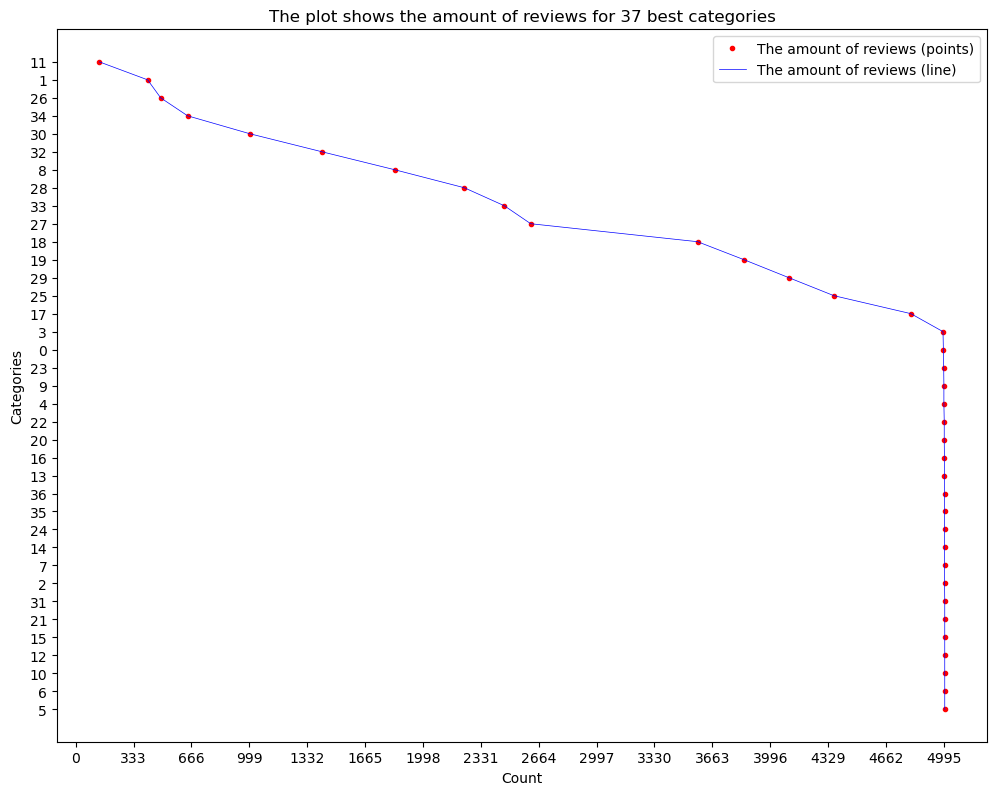

In [54]:
visualize_data(filter_sort(data, only_one_category=True, threshold=0))

In [55]:
print(f'final_clases ({len(label_dict)}):\n{label_dict}')

final_clases (37):
{'Pharmacy': 0, 'Paintball': 1, 'Hotels': 2, 'Hospitals': 3, 'Cinema': 4, 'Pizza': 5, 'Massage': 6, 'Museums': 7, 'Climbing': 8, 'Tattoo': 9, 'Steakhouses': 10, 'Embassy': 11, 'Grocery': 12, 'Soup': 13, 'Bakeries': 14, 'Bars': 15, 'Transportation': 16, 'Airports': 17, 'Kebab': 18, 'Beaches': 19, 'Noodles': 20, 'Sandwiches': 21, 'Golf': 22, 'Barbers': 23, 'Diners': 24, 'Parking': 25, 'Diving': 26, 'Karaoke': 27, 'Fishing': 28, 'Bowling': 29, 'Saunas': 30, 'Seafood': 31, 'Perfume': 32, 'Libraries': 33, 'Hostels': 34, 'Tours': 35, 'Cafes': 36}


In [59]:
with open(f'../data/nn_small_strict_data_{int(time.time())}.pickle', 'wb') as handle:
    pickle.dump(data, handle)

In [60]:
with open(f'../data/dictionary_small_strict_{int(time.time())}.pickle', 'wb') as handle:
    pickle.dump(label_dict, handle)

In [ ]:
# main_categories = set([
#     # active live
#     'Beaches', 'Bike Rentals', 'Bowling', 'Climbing', 'Diving', 'Fishing',
#     'Fitness & Instruction', 'Golf', 'Kids Activities', 'Paintball', 'Swimming Pools',
    
#     # arts & entertainment
#     'Museums', 'Cinema', 'Cultural Center', 'Entertainment',
    
#     # automotive
#     'Auto Repair', 'Auto Security', 'Car Wash', 'Gas Stations', 'Parking',
    
#     # Beauty & Spas
#     'Barbers', 'Massage', 'Perfume', 'Tattoo',
    
#     # Education
#     'Colleges & Universities', 'Educational Services',
    
#     # Financial Services
#     'Currency Exchange',
    
#     # Food
#     'Bakeries', 'Food Trucks', 'Grocery',
    
#     # Health & Medical
#     'Hospitals', 'Pharmacy', 'Saunas',
    
#     # Hotels & Travel
#     'Airports', 'Car Rental', 'Motorcycle Rental', 'Hostels', 'Hotels', 'Tours', 'Ski Resorts',
#     'Train Stations', 'Transportation', 'Travel Services',
    
#     # Nightlife
#     'Adult Entertainment', 'Bars', 'Dance Clubs', 'Karaoke'
    
#     # Public Services & Government
#     'Embassy', 'Libraries', 'Police Departments', 'Post Offices',

#     # Restaurants
#     'Cafes', 'Diners', 'Fast Food', 'Kebab', 'Pizza', 'Noodles',
#     'Sandwiches', 'Seafood', 'Soup', 'Steakhouses', 'Sushi Bars'
# ])